<h1 style="font-family:Impact,Arial;font-size:30px;">37004 Interest Rates and Credit Risk Models - Spring 2024</h1>
<h1 style="font-family:Impact,Arial;font-size:45px;">Assignment Part 2</h1>
<h2 style="font-family:Arial;">Erik Schl&ouml;gl</h2>
<p><small> School of Mathematical &amp; Physical Sciences<br>
University of Technology Sydney
</small></p>
<p>
<a href="mailto:Erik.Schlogl@uts.edu.au?Subject=37000 JIT" target="_blank">
<small><font color=MediumVioletRed>Erik.Schlogl@uts.edu.au</font></small></a>
</p>
<hr style="height:5px;border:none;color:#333;background-color:#333;" />


Consider the data files <code>daily-treasury-rates2018.csv</code>, <code>daily-treasury-rates2019.csv</code>, <code>daily-treasury-rates2020.csv</code>, <code>daily-treasury-rates2021.csv</code> and <code>daily-treasury-rates2022.csv</code>. They contain the United States Treasury's "Daily Yield Curve" data (sourced from www.treasury.gov) for the years 2018 to 2022. These rates are what the US Treasury calls "CMT rates" (see
https://www.treasury.gov/resource-center/faqs/Interest-Rates/Pages/faq.aspx).


# Import package


In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import fsolve as solver
from scipy.stats import norm
from matplotlib import pyplot as plt

<H2>Task 1:</H2>
Convert these rates into continuously compounded yields. <I>(1 mark)</I>


In [2]:
df = pd.DataFrame({})
for year in [2018, 2019, 2020, 2021, 2022]:
    df = pd.concat([df, pd.read_csv(f'daily-treasury-rates{year}.csv')], ignore_index=True)
df['Date']=pd.to_datetime(df['Date'], format='%m/%d/%Y')
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
maturity = pd.DataFrame({
    'Date': df['Date']
})
for i in [1,2,3,6]:
    maturity[f'{i} Mo']=((maturity['Date'] + pd.DateOffset(months=i))-maturity['Date']).dt.days
for i in [1,2,3,5,7,10,20,30]:
    maturity[f'{i} Yr']=((maturity['Date'] + pd.DateOffset(years=i))-maturity['Date']).dt.days

In [3]:
cont_rate = pd.DataFrame({
    'Date': df['Date']
})
for column in df.columns[1:]:
    cont_rate[column]=2*np.log(1+df[column]/200)
print('Continuously compounded yields')
cont_rate

Continuously compounded yields


,Date,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,2018-01-02,0.012859,NaN,0.014348,0.016036,0.018217,0.019108,0.020000,0.022374,0.023660,0.024450,0.026227,0.027904
1,2018-01-03,0.012859,NaN,0.014051,0.015837,0.018019,0.019307,0.020099,0.022374,0.023561,0.024252,0.026030,0.027609
2,2018-01-04,0.012759,NaN,0.014051,0.015936,0.018118,0.019505,0.020396,0.022572,0.023660,0.024450,0.026030,0.027707
3,2018-01-05,0.012660,NaN,0.013852,0.015738,0.017919,0.019505,0.020495,0.022770,0.023857,0.024549,0.026227,0.027904
4,2018-01-08,0.012958,NaN,0.014448,0.015936,0.017820,0.019505,0.020594,0.022770,0.023956,0.024746,0.026326,0.027904
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,2022-08-29,0.024351,0.027313,0.029482,0.032927,0.034009,0.033911,0.034206,0.032436,0.031845,0.030959,0.034697,0.032239
1166,2022-08-30,0.024154,0.027115,0.029482,0.032829,0.034501,0.034304,0.034402,0.032436,0.031944,0.030861,0.034599,0.032042
1167,2022-08-31,0.023857,0.027017,0.029383,0.032927,0.034697,0.034206,0.034304,0.032731,0.032239,0.031255,0.034992,0.032436
1168,2022-09-01,0.025141,0.027806,0.029482,0.033124,0.034796,0.034796,0.035090,0.033616,0.033321,0.032337,0.036073,0.033419


In this data set, the <I>time to maturity</I> (not the time of maturity) is constant in each column. Thus, from the data in each column, we can obtain an estimate of the variance of the day-to-day changes in a continuously compounded yield with a given time to maturity. In order to relate this back to an HJM model, we need the dynamics of rates with fixed time to maturity in the model.

We start with the instantaneous forward rates. The instantaneous forward rates $f(t,T)$ modelled in HJM have a fixed time of maturity $T$, with dynamics

$$
f(t,T)=f(0,T)+\int_0^t\sigma(u,T)\int_u^T\sigma(u,s)dsdu+\int_0^t\sigma(u,T)dW_{\beta}(u)\quad\forall\
t\in[0,T]
$$

Define instantaneous forward rates $r(t,x)$ with constant time to maturity $x$ by

$$
r(t,x)=f(t,t+x)
$$

The dynamics of $r(t,x)$ are given by the <I>Musiela equation</I> (for a proof, see e.g. Section 18.3 of Bj&ouml;rk, T. (1998) <I>Arbitrage Theory in Continuous Time</I>, Oxford University Press)

$$
r(t,x)=r(0,x)+\int_0^t\left(\frac{\partial}{\partial x}r(u,x)+\sigma(u,u+x)\int_0^x\sigma(u,u+s)ds\right)du+\int_0^t\sigma(u,u+x)dW_{\beta}(u)
$$


The continously compounded yield with constant time to maturity $x$ is

$$
y(t,x)=\frac1x\int_0^xr(t,s)ds
$$

Thus we have for the change in the continously compounded yield with constant time to maturity over a $\Delta t$ time step:

$$
y(t+\Delta t,x)-y(t,x)=\frac1x\int_0^x\left(\int_t^{t+\Delta t}\left(\frac{\partial}{\partial s}r(u,s)+\sigma(u,u+s)\int_0^s\sigma(u,u+v)dv\right)du+\int_t^{t+\Delta t}\sigma(u,u+s)dW_{\beta}(u)\right)ds
$$

Note that the drift will contribute to the variance of changes in the continously compounded yield via

$$
\frac{\partial}{\partial s}r(u,s),
$$

but for practical purposes this is negligible. Thus

$$
\text{Var}[y(t+\Delta t,x)-y(t,x)] \approx \text{Var}\left[\frac1x\int_0^x\int_t^{t+\Delta t}\sigma(u,u+s)dW_{\beta}(u)ds\right]\\
= \text{Var}\left[\frac1x\int_t^{t+\Delta t}\int_0^x\nu e^{-a(u+s-u)}dsdW_{\beta}(u)\right]\\
= \text{Var}\left[\frac1x\int_t^{t+\Delta t}\frac{\nu}a(1-e^{-ax})dW_{\beta}(u)\right]\\
= \left(\frac1x\frac{\nu}a(1-e^{-ax})\right)^2\Delta t
$$


<H2>Task 2:</H2>
Assuming a one-factor Gauss/Markov HJM model with mean reversion fixed at $a = 0.1$, use all the data for the six-month yields to determine an appropriate choice of the volatility level $$\nu$$ (notation as above). For simplicity, you may assume that the data observations are equally spaced in calendar time. <I>(3 marks)</I>


In [4]:
def volatility_level_cal(maturity, a, today):
    data = cont_rate[cont_rate['Date']<=pd.to_datetime(today, format='%Y-%m-%d')]
    var = np.var(list(data[maturity].diff().dropna()), ddof=1)
    delta_t = 1/365
    x = 0.5 if maturity=='6 Mo' else 1/12 if maturity=='1 Mo' else 30
    return np.sqrt(var/delta_t)*x*a/(1-np.exp(-a*x))
print('The volatility level:', volatility_level_cal('6 Mo', 0.1, '2022-12-31'))

The volatility level: 0.005859687691400121


<H2>Task 3:</H2>
Assuming a one-factor Gauss/Markov HJM model, use all the data for the one-month and thirty-year yields to determine an appropriate choice of the mean reversion parameter $a$ and volatility level $\nu$. For simplicity, you may assume that the data observations are equally spaced in calendar time. <I>(3 marks)</I>


In [5]:
def an_calculator(x, today):
    results = []
    for col in ['1 Mo', '30 Yr']:
        results.append(volatility_level_cal(col, x[0], today)-x[1])
    return results
[a, n] = solver(an_calculator, np.ones(2), args=('2022-12-31'))
print('Mean reversion parameter:', a)
print('Volatility level:', n)

Mean reversion parameter: -0.025100959969597176
Volatility level: 0.0062843237151271065


A way in which the performance of a model for risk management purposes can be <B>backtested</B> is to use historical interest data to analyse what would have happened if one had used the model to hedge a derivative security in the past. This motivates the following Task:


<H2>Task 4:</H2>
Suppose that at the beginning of January 2022 you have sold an at-the-money European receiver swaption, expiring in six months, where the frequency of payments of the underlying swap is quarterly and the swap ends five years after the swaption expiry. If you hedge this swaption with rebalancing on every day for which there is data, using the natural hedge instruments of the constituent zero coupon bond options, what would be your profit/loss when this option matures? Assume that swaption price and hedges are calculated using a one-factor Gauss/Markov HJM model with the parameters determined as in Task 3, but <B>using only data which would have been available at the time the swaption was sold</B>. Assume that any profit/loss is invested/borrowed by buying/selling the zero coupon bond maturing at the same time as the swaption. Use loglinear interpolation of zero coupon bond prices, but only where necessary. Repeat
this for a (otherwise identical) swaption sold at the beginning of, respectively, April 2021, July 2021, and October 2021. Discuss the possible causes of profit/loss. <I>(13 marks)</I>


In [6]:
def swap_calculator(date):
    start_date = pd.to_datetime(date[0], format='%Y-%m-%d')
    df_2022 = cont_rate[cont_rate['Date']>=start_date].reset_index(drop=True)
    maturity_2022 = maturity[maturity['Date']>=start_date].reset_index(drop=True)
    payments = [pd.to_datetime(date[1], format='%Y-%m-%d')]
    for i in range(4*5):
        payments.append(payments[0]+pd.DateOffset(months=3*(i+1)))
    payments_gap = [(payments[x]-payments[x-1]).days/((payments[x-1]+pd.DateOffset(years=1))-payments[x-1]).days for x in range(1,len(payments))]

    def year_transform(index, t):
        runner = maturity_2022.iloc[index,0]
        days = int(t)
        year = 0
        while days>0:
            next_runner = runner + pd.DateOffset(years=1)
            if days>(next_runner-runner).days:
                year += 1
                days -= (next_runner-runner).days
            else:
                year += days/(next_runner-runner).days
                days -= days
            runner = next_runner
        return year

    def df_calculator(index, t):
        if t<0 or t>maturity_2022.iloc[index,12]:
            return ValueError("t must be in range [0,30]")
        pos = len(list(filter(lambda x:x<=t, list(maturity_2022.iloc[index,1:]))))
        if t in list(maturity_2022.iloc[index,1:]):
            r = df_2022.iloc[index,pos]
            return np.exp(-r*year_transform(index, t))
        T1 = max(list(filter(lambda x:x<t, list(maturity_2022.iloc[index,1:])))+[0])
        T2 = min(list(filter(lambda x:x>t, list(maturity_2022.iloc[index,1:]))))
        r1 = df_2022.iloc[index,len(list(filter(lambda x:x<=T1, list(maturity_2022.iloc[index,1:]))))] if T1!=0 else 0
        r2 = df_2022.iloc[index,len(list(filter(lambda x:x<=T2, list(maturity_2022.iloc[index,1:]))))]
        T1_trans = year_transform(index, T1)
        T2_trans = year_transform(index, T2)
        B1 = np.exp(-r1*T1_trans)
        B2 = np.exp(-r2*T2_trans)
        return B1*((B2/B1)**((t-T1)/(T2-T1)))
    
    def present_omega(index):
        today = maturity_2022.iloc[index,0]
        dfs = list(map(lambda x: df_calculator(index, (x-today).days), payments))
        return (dfs[0]-dfs[-1])/sum([payments_gap[i-1]*dfs[i] for i in range(1,len(dfs))])

    def bond_calculator(index, t, T, mean_reversion, volatility_level, r=None, ret=None):
        BT = df_calculator(index, T)
        Bt = df_calculator(index, t)
        T_trans = year_transform(index, T)
        t_trans = year_transform(index, t)
        A = (BT/Bt)*np.exp(-np.exp(-2*(t_trans+T_trans)*mean_reversion)*(np.exp(mean_reversion*t_trans)-1)*(volatility_level**2)*(np.exp(2*mean_reversion*t_trans)+np.exp(3*mean_reversion*t_trans)-np.exp(2*mean_reversion*T_trans)-4*np.exp(mean_reversion*(2*t_trans+T_trans))+3*np.exp(mean_reversion*(t_trans+2*T_trans)))/(4*(mean_reversion**3)))
        B = (np.exp(-mean_reversion*t_trans)-np.exp(-mean_reversion*T_trans))/mean_reversion
        if ret:
            return A,B
        return A*np.exp(-B*r)
    
    def short_rate_solver(r, index, lk, mean_reversion, volatility_level):
        today = df_2022.iloc[index,0]
        payments_date = list(map(lambda x: (x-today).days,payments))
        Bs = list(map(lambda x:bond_calculator(index, payments_date[0], x, mean_reversion, volatility_level, r),payments_date[1:]))
        BTn = 1-lk*sum([Bs[x]*payments_gap[x] for x in range(len(Bs))])
        A,B = bond_calculator(index, payments_date[0], payments_date[-1], mean_reversion, volatility_level, ret=True)
        return r+np.log(BTn/A)/B
    
    def bond_option_info_calculator(Ti, index, r, mean_reversion, volatility_level):
        today = df_2022.iloc[index,0]
        T0 = (payments[0]-today).days
        B_star = bond_calculator(index, T0, Ti, mean_reversion, volatility_level, r)
        BTi = df_calculator(index, Ti)
        BT0 = df_calculator(index, T0)
        T0_trans = year_transform(index, T0)
        Ti_trans = year_transform(index, Ti)
        chi = np.exp(-mean_reversion*Ti_trans)*(volatility_level**2)*(np.exp(mean_reversion*T0_trans)-np.exp(-mean_reversion*T0_trans))*((np.exp(mean_reversion*(T0_trans-Ti_trans)/2)-np.exp(-mean_reversion*(T0_trans-Ti_trans)/2))**2)/(2*(mean_reversion**3))
        h1 = (np.log(BTi/(BT0*B_star))+chi/2)/np.sqrt(chi)
        h2 = (np.log(BTi/(BT0*B_star))-chi/2)/np.sqrt(chi)
        def previous_bond_calculator(BT0_new, BTi_new):
            return BTi_new*norm.cdf(h1)-BT0_new*B_star*norm.cdf(h2)
        return [BTi*norm.cdf(h1)-BT0*B_star*norm.cdf(h2), previous_bond_calculator]
    
    def value_calculator(index, r, lk, mean_reversion, volatility_level):
        today = df_2022.iloc[index,0]
        payments_date = list(map(lambda x: (x-today).days,payments[1:]))
        bond_option_info = list(map(lambda x: bond_option_info_calculator(x, index, r, mean_reversion, volatility_level), payments_date))
        Cs = list(map(lambda x: x[0],bond_option_info))
        Calculators = list(map(lambda x: x[1],bond_option_info))
        return Cs[-1]+lk*sum([Cs[x]*payments_gap[x] for x in range(len(Cs))]), Calculators
    
    def updated_value_calculator(index, calculators, lk):
        today = df_2022.iloc[index,0]
        payments_date = list(map(lambda x: (x-today).days,payments[1:]))
        T0 = (payments[0]-today).days
        BT0 = df_calculator(index, T0)
        args = list(map(lambda x: [BT0, df_calculator(index, x)],payments_date))
        Cs = [calculators[i](args[i][0], args[i][1]) for i in range(len(calculators))]
        return Cs[-1]+lk*sum([Cs[x]*payments_gap[x] for x in range(len(Cs))])


    lk = present_omega(0)
    index = 0
    payoff = 0
    values = []
    hedge_port_value=[]
    payoffs = []
    history_calculators = []
    [mean_reversion, volatility_level] = solver(an_calculator, np.ones(2), args=(date[0]))
    while df_2022.iloc[index,0]<=payments[0]:
        value = None
        today = df_2022.iloc[index,0]
        if df_2022.iloc[index,0]<payments[0]:
            r = solver(short_rate_solver,x0=0, args=(index, lk, mean_reversion, volatility_level))[0]
            value, calculators = value_calculator(index, r, lk, mean_reversion, volatility_level)
            if len(history_calculators)!=0:
                hedge_port_value.append(updated_value_calculator(index, history_calculators, lk))
            history_calculators=calculators
        else:
            Bs = list(map(lambda x: df_calculator(index, (x-payments[0]).days), payments[1:]))
            value = max(0, Bs[-1]+lk*sum([Bs[x]*payments_gap[x] for x in range(len(Bs))])-1)
            hedge_port_value.append(updated_value_calculator(index, history_calculators, lk))
        values.append(value)
        today = df_2022.iloc[index,0]
        if len(values)!=1:
            payoffs.append(hedge_port_value[-1]-values[-1])
        else:
            hedge_port_value.append(values[-1])
            payoffs.append(0)
        payoff +=payoffs[-1]/df_calculator(index, (payments[0]-today).days)
        index += 1
    
    return payoff, pd.DataFrame({
        "Payoff": payoffs,
        "Value": values,
        "Hedge Portfolio Value": hedge_port_value,
    })

-------------------------------------------------------[2022-01-03 to 2022-07-01]-------------------------------------------------------
Payoff: -0.0033701385822505303


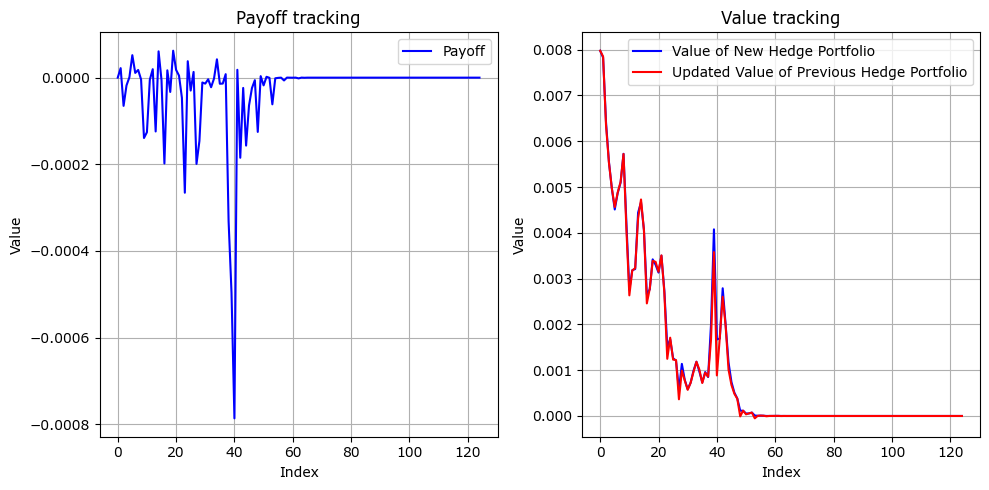

-------------------------------------------------------[2021-10-01 to 2022-04-01]-------------------------------------------------------
Payoff: -0.002160383751078409


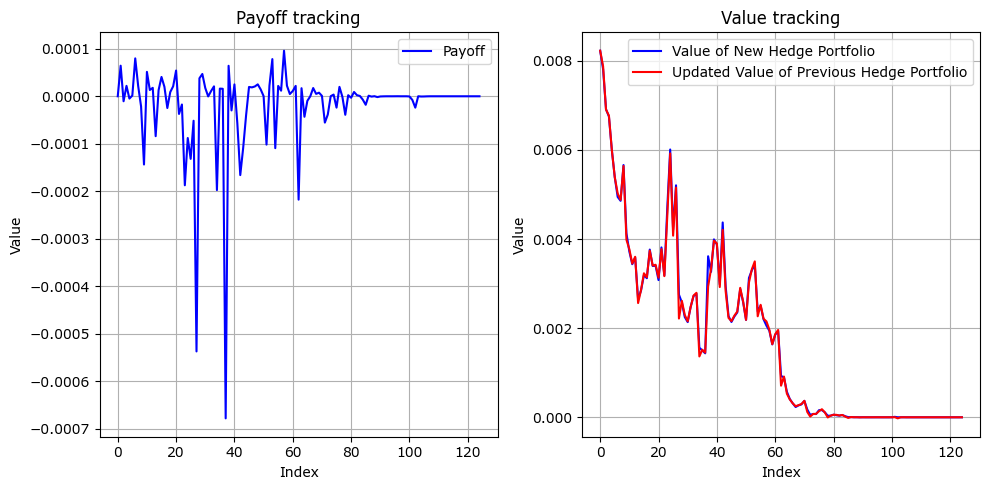

-------------------------------------------------------[2021-07-01 to 2022-01-03]-------------------------------------------------------
Payoff: -0.0019234211684794106


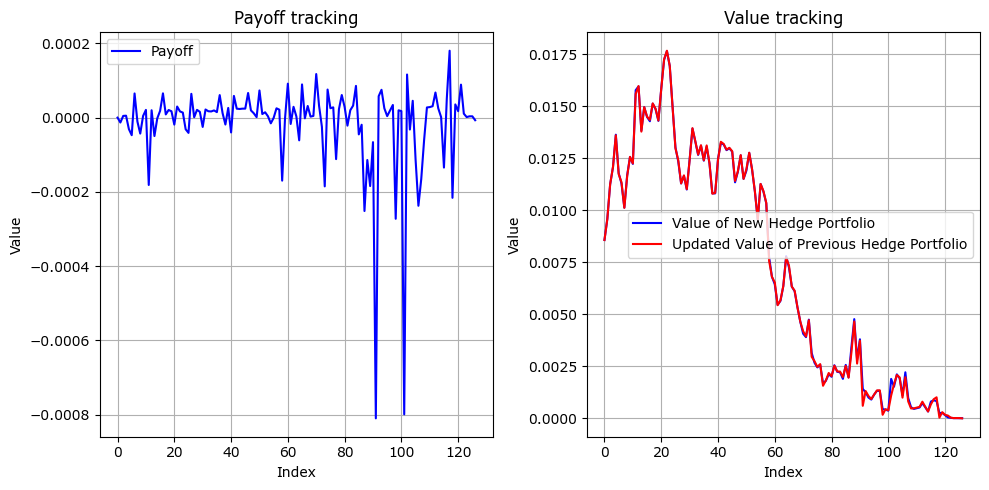

-------------------------------------------------------[2021-04-01 to 2021-10-01]-------------------------------------------------------
Payoff: 0.0011535630006467182


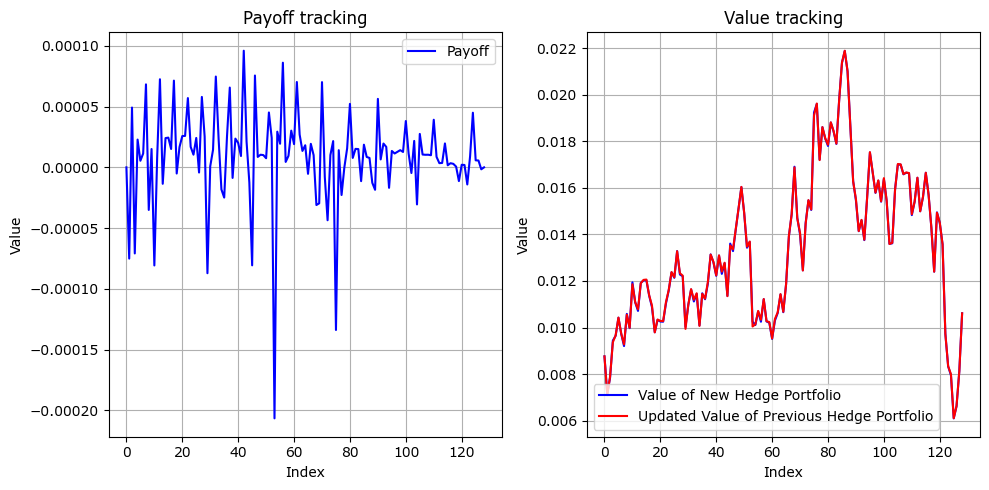

In [7]:
for date in [['2022-01-03', '2022-07-01'], ['2021-10-01', '2022-04-01'], ['2021-07-01', '2022-01-03'], ['2021-04-01', '2021-10-01']]:
    print(f'-------------------------------------------------------[{date[0]} to {date[1]}]-------------------------------------------------------')
    payoff, frame = swap_calculator(date)
    print('Payoff:', payoff)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(frame['Payoff'], label='Payoff', color='blue')
    ax[0].set_xlabel('Index')
    ax[0].set_ylabel('Value')
    ax[0].set_title('Payoff tracking')
    ax[0].legend()
    ax[0].grid(True)
    ax[1].plot(frame['Value'], label='Value of New Hedge Portfolio', color='blue')
    ax[1].plot(frame['Hedge Portfolio Value'], label='Updated Value of Previous Hedge Portfolio', color='red')
    ax[1].set_xlabel('Index')
    ax[1].set_ylabel('Value')
    ax[1].set_title('Value tracking')
    ax[1].legend()
    ax[1].grid(True)
    plt.tight_layout()
    plt.show()

Comment on the payoff:
- In the perfect world, where the term structure is constant and we can hedge continously, the portfolio can be perfectly replicated and hedged. This would lead to the zero payoff at the maturity. However, in the world where the data is taken, we cannot take the hedge continously and the term structure change over days, the payoff is different from zero. However, as we tried to hedge every day, we have tried to make the payoff approximately reach to zero. However, as it is not perfect enough, the payoff is still different from 0.
- From the plots of value tracking, we can see that the red line cannot totally track the blue line due to the change in the term structure, this cause the payoff at the maturity.
- For the swaptions that are sold on 03/01/2022, 01/10/2021 and 01/07/2021, the payoffs tend to appear at the beginning of the periods. Furthermore, we can see that their red lines do not fully cover the blue lines in the plots of value tracking as the swaption that is sold on 01/04/2021. Since then, their payoffs at the maturity tend to be higher than the swaption that is sold on 01/04/2021.